In [71]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from pacmap import PaCMAP

patient_id = 33
mn_ratio = 30
fp_ratio = 15
lr = 0.05

In [72]:
# Format data
embedding_path = f'output/jackal/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'

with open(embedding_path, 'rb') as f:
    patient_data = pickle.load(f)

patient_embeddings = patient_data['patient_embeddings'] # (num_files, 32, 512)
print('patient_embeddings shape: ', patient_embeddings.shape)
flat_embeddings = patient_embeddings.reshape(-1, patient_embeddings.shape[-1])
print('flat_embeddings shape: ', flat_embeddings.shape)

# Load sleep metadata
sleep_data = pd.read_excel('metadata/cleaned_sleep.xlsx')

# Convert datetime columns
sleep_data['OnsetDatetime'] = pd.to_datetime(sleep_data['OnsetDatetime'])
sleep_data['OffsetDatetime'] = pd.to_datetime(sleep_data['OffsetDatetime'])

patient_embeddings shape:  (536, 32, 512)
flat_embeddings shape:  (17152, 512)


In [73]:
# Set up sleep tagging functions

def find_sleep_stage(start_time, stop_time, sleep_data, patient_id, certainty_threshold):
    """Find sleep stage for a given time window and patient."""
    patient_sleep = sleep_data[
        (sleep_data['PatID'] == patient_id) & 
        (sleep_data['AvgCertainty'] >= certainty_threshold)
    ]
    
    if len(patient_sleep) == 0:
        return 'unknown'
    
    # Check for overlapping sleep stages
    overlapping_stages = patient_sleep[
        (patient_sleep['OnsetDatetime'] <= stop_time) & 
        (patient_sleep['OffsetDatetime'] >= start_time)
    ]
    
    if len(overlapping_stages) > 0:
        sleep_stage = overlapping_stages.iloc[0]['SleepCat']
        # Group N2 and N3 into N
        return 'N' if sleep_stage in ['N2', 'N3'] else sleep_stage
    return 'unknown'

def tag_points(patient_id, sleep_data, certainty_threshold):
    """Tag points with sleep stage metadata and update patient's data."""
    print("Tagging patient data with sleep metadata...")
    embedding_path = f'output/jackal/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'

    with open(embedding_path, 'rb') as f:
        data = pickle.load(f)
    
    print("\nProcessing patient data...")
    
    # Get this patient's sleep metadata
    pat_sleep = sleep_data[
        (sleep_data['PatID'] == f"Epat{patient_id}") & 
        (sleep_data['AvgCertainty'] >= certainty_threshold)
    ]
    
    # Get number of files from the embeddings shape
    n_files = data['patient_embeddings'].shape[0]
    print(f"Number of files for patient {patient_id}: {n_files}")
    
    if len(pat_sleep) == 0:
        print(f"No sleep events found for Epat{patient_id}")
        # Tag all points as unknown for this patient
        sleep_stages = ['unknown'] * (n_files * 32)  # 32 windows per file
        print(f"Added {len(sleep_stages)} 'unknown' labels")
    else:
        print(f"Found {len(pat_sleep)} sleep events")
        # Tag each window for this patient
        sleep_stages = []
        file_start_times = data['start_times']
        
        for file_idx, file_start in enumerate(file_start_times):
            # Calculate window start times for this file
            window_starts = [file_start + pd.Timedelta(seconds=30*i) for i in range(32)]
            window_ends = [start + pd.Timedelta(seconds=60) for start in window_starts]  # 60-second windows
            
            # Tag each window
            for window_start, window_end in zip(window_starts, window_ends):
                stage = find_sleep_stage(window_start, window_end, sleep_data, f"Epat{patient_id}", certainty_threshold)
                sleep_stages.append(stage)
        
        print(f"Added {len(sleep_stages)} labels")
    
    # Print summary statistics
    stage_counts = pd.Series(sleep_stages).value_counts()
    print("\nSleep stage distribution:")
    for stage, count in stage_counts.items():
        print(f"{stage}: {count}")
    
    # Update sleep_labels in data
    data['sleep_labels'] = sleep_stages
    print("\nSleep labels shape:", len(data['sleep_labels']))
    print("Patient embeddings shape:", data['patient_embeddings'].shape)
    
    # Save updated data back to file
    print("\nSaving updated patient data...")
    with open(embedding_path, 'wb') as f:
        pickle.dump(data, f)

In [74]:
tag_points(patient_id, sleep_data, 0.6)

# Reload the updated data
embedding_path = f'output/jackal/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'
with open(embedding_path, 'rb') as f:
    patient_data = pickle.load(f)

sleep_labels = patient_data['sleep_labels']
print("Sleep labels shape:", len(sleep_labels))

Tagging patient data with sleep metadata...

Processing patient data...
Number of files for patient 33: 536
Found 18 sleep events
Added 17152 labels

Sleep stage distribution:
unknown: 16492
N: 320
W: 297
R: 43

Sleep labels shape: 17152
Patient embeddings shape: (536, 32, 512)

Saving updated patient data...
Sleep labels shape: 17152


In [75]:
print(sleep_labels)

['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown'

In [76]:
pacmap_params = {
    'n_components': 2,
    'MN_ratio': 30,
    'FP_ratio': 15,
    'distance': 'angular',
    'verbose': True,
    'lr': 0.05,
    'num_iters': 900
}

project_to_2d = PaCMAP(**pacmap_params)
manifold_2d = project_to_2d.fit_transform(flat_embeddings)

Applied PCA, the dimensionality becomes 100
PaCMAP(n_neighbors=10, n_MN=300, n_FP=150, distance=angular, lr=0.05, n_iters=(100, 100, 900), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((171520, 2), (5145600, 2), (2572800, 2))
Initial Loss: 1809484.0
Iteration:   10, Loss: 1663157.250000
Iteration:   20, Loss: 1504161.250000
Iteration:   30, Loss: 1412397.250000
Iteration:   40, Loss: 1339255.500000
Iteration:   50, Loss: 1265143.000000
Iteration:   60, Loss: 1154958.125000
Iteration:   70, Loss: 1039294.250000
Iteration:   80, Loss: 909948.000000
Iteration:   90, Loss: 737067.500000
Iteration:  100, Loss: 463926.437500
Iteration:  110, Loss: 376213.468750
Iteration:  120, Loss: 331940.187500
Iteration:  130, Loss: 307284.468750
Iteration:  140, Loss: 291828.718750
Iteration:  150, Loss: 281220.750000
Iteration:  160, Loss: 273545.968750
Iteration:  170,

Plotting 297 points for W
Plotting 320 points for N
Plotting 43 points for R


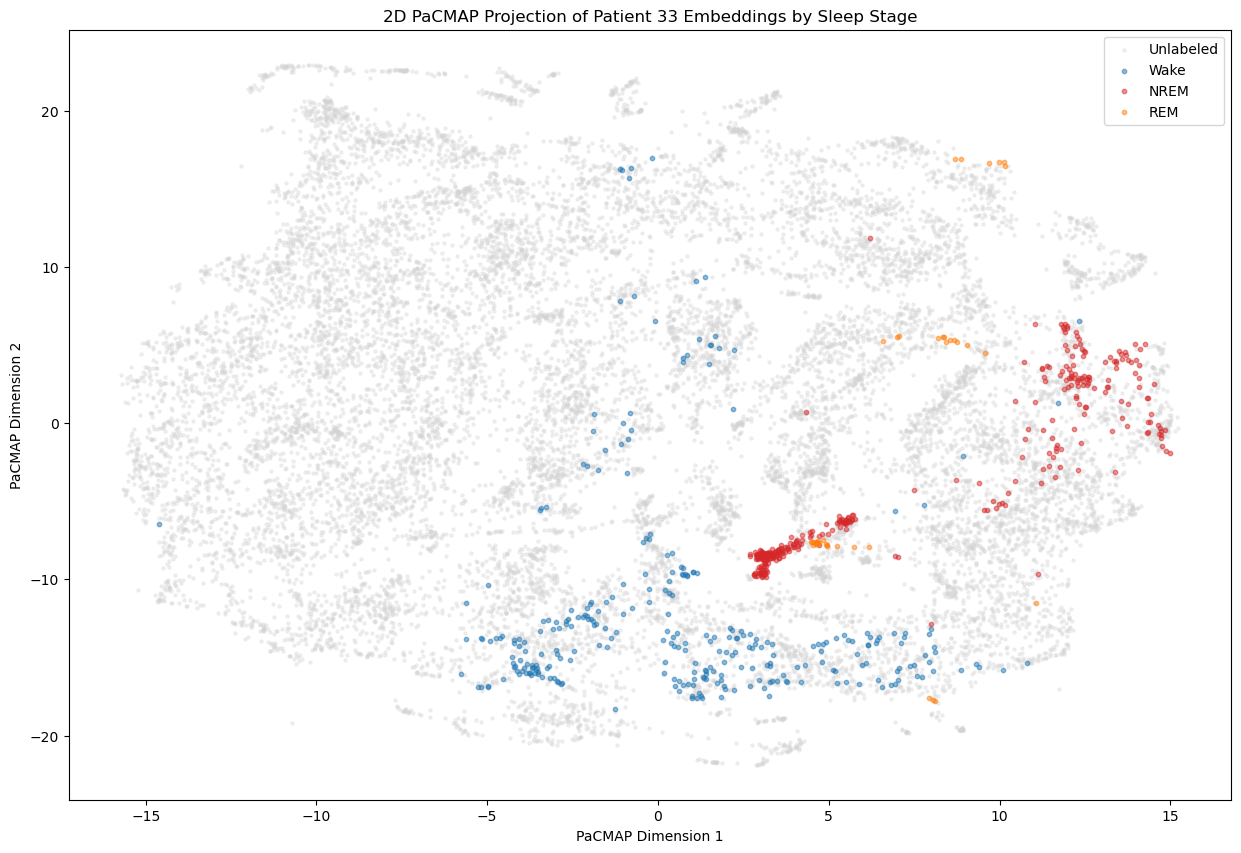

In [77]:
# Plot results
plt.figure(figsize=(15,10))

# Plot unlabeled points in grey first
labeled_mask = np.isin(sleep_labels, ['W', 'N', 'R'])
plt.scatter(manifold_2d[~labeled_mask,0], manifold_2d[~labeled_mask,1],
           c='lightgray', alpha=0.3, s=5, label='Unlabeled')

# Define color and label mappings
sleep_colors = {
    'W': '#1f77b4',  # Wake - blue
    'N': '#d62728',  # NREM - red
    'R': '#ff7f0e'   # REM - orange
}
sleep_names = {
    'W': 'Wake',
    'N': 'NREM',
    'R': 'REM'
}

# Plot labeled points on top
for label in sleep_colors:
    mask = np.array(sleep_labels) == label  # Convert to numpy array for boolean indexing
    if np.any(mask):  # Only plot if there are any points with this label
        plt.scatter(manifold_2d[mask,0], manifold_2d[mask,1],
                   c=sleep_colors[label],
                   label=sleep_names[label],
                   alpha=0.5, s=10)
        print(f"Plotting {np.sum(mask)} points for {label}")  # Debug print

plt.title(f'2D PaCMAP Projection of Patient {patient_id} Embeddings by Sleep Stage')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.legend()

In [78]:
seizure_data = pd.read_excel('metadata/ictal_event_metadata.xlsx')
patient_seizures = seizure_data[(seizure_data['Pat ID'] == f"Epat{patient_id}")]

if len(patient_seizures) == 0:
    print(f"No seizure events found for patient {patient_id}")
else:
    print(f"Found {len(patient_seizures)} seizure events for patient {patient_id}")

num_seizure_events = len(patient_seizures)

# Process timestamps for the filtered data
patient_seizures = patient_seizures[
    ~(
        patient_seizures['Date (MM:DD:YYYY)'].isna() |
        patient_seizures['Electrographical Ictal Onset (HH:MM:SS) 24Hr'].isna() |
        patient_seizures['Electrographic Ictal Offset (HH:MM:SS) 24Hr'].isna()
    )
]

# Convert date format and create datetime objects
patient_seizures['Date (MM:DD:YYYY)'] = patient_seizures['Date (MM:DD:YYYY)'].apply(lambda x: x.split(':')[0] + '/' + x.split(':')[1] + '/' + x.split(':')[2])

date_format = '%m/%d/%Y %H:%M:%S'
patient_seizures['onset_datetime'] = pd.to_datetime(
    patient_seizures['Date (MM:DD:YYYY)'] + ' ' + 
    patient_seizures['Electrographical Ictal Onset (HH:MM:SS) 24Hr'],
    format=date_format
)

patient_seizures['offset_datetime'] = pd.to_datetime(
    patient_seizures['Date (MM:DD:YYYY)'] + ' ' + 
    patient_seizures['Electrographic Ictal Offset (HH:MM:SS) 24Hr'],
    format=date_format
)

print(patient_seizures)

Found 2 seizure events for patient 33
     Pat ID Event Number (Matches EMU Final Report) Date (MM:DD:YYYY)  \
573  Epat33                                       2         7/20/2020   

    Clinical Ictal Onset (HH:MM:SS) 24Hr  \
573                             09:12:51   

    Electrographical Ictal Onset (HH:MM:SS) 24Hr  \
573                                     09:12:54   

    Electrographic Ictal Offset (HH:MM:SS) 24Hr  \
573                                    09:14:54   

    Seizure Type (FAS; FIAS; FBTC; Non-electrographic; Subclinical; Unknown)  \
573                                               FBTC                         

             Testing Performed? Testing Day/Time (MM:DD:YYYY-HH:MM:SS)  \
573  Testing performed:Impaired                               09:13:20   

    Testing Comments  ... PZ leads 4s PZ leads 5s  \
573              NaN  ...         NaN         NaN   

                                      PZ leads 6s PZ leads 7s     PZ leads 8s  \
573  LA_1-1;LA_3-9;L

In [79]:
# Get original file start times
file_start_times = patient_data['start_times']

# Create expanded list of start times for each window
expanded_start_times = []
for file_start in file_start_times:
    # For each file, create 32 window start times with 30-second strides
    window_starts = [file_start + pd.Timedelta(seconds=30*i) for i in range(32)]
    expanded_start_times.extend(window_starts)

# Convert to numpy array if needed
expanded_start_times = np.array(expanded_start_times)

# Verify dimensions
print("Number of windows:", len(expanded_start_times))
print("Flat embeddings shape:", flat_embeddings.shape)
assert len(expanded_start_times) == flat_embeddings.shape[0], "Dimensions should match"

# Create mask for seizure windows
seizure_mask = np.zeros(len(expanded_start_times), dtype=bool)

# Each window is 30 seconds long
window_duration = pd.Timedelta(seconds=30)

# Check each window for overlap with seizures
for i, window_start in enumerate(expanded_start_times):
    window_end = window_start + window_duration
    
    # Check if window overlaps with any seizure
    for _, seizure in patient_seizures.iterrows():
        if (
            # Window starts during seizure
            (window_start >= seizure['onset_datetime'] and window_start <= seizure['offset_datetime']) or
            # Window ends during seizure  
            (window_end >= seizure['onset_datetime'] and window_end <= seizure['offset_datetime']) or
            # Window contains entire seizure
            (window_start <= seizure['onset_datetime'] and window_end >= seizure['offset_datetime'])
        ):
            seizure_mask[i] = True
            break

print(f"Found {seizure_mask.sum()} windows containing seizure activity")

Number of windows: 17152
Flat embeddings shape: (17152, 512)
Found 0 windows containing seizure activity


In [80]:
# Create mask for preictal windows (5 minutes before seizure onset)
preictal_mask = np.zeros(len(expanded_start_times), dtype=bool)
preictal_window = pd.Timedelta(minutes=5)

# Find the start of each seizure sequence
seizure_sequence_starts = []
for i in range(len(seizure_mask)):
    if seizure_mask[i] and (i == 0 or not seizure_mask[i-1]):
        seizure_sequence_starts.append(i)

# For each seizure sequence start, mark the preceding 5 minutes as preictal
for seizure_start_idx in seizure_sequence_starts:
    seizure_start_time = expanded_start_times[seizure_start_idx]
    
    # Look at all windows before this seizure
    for i in range(seizure_start_idx):
        window_time = expanded_start_times[i]
        time_to_seizure = seizure_start_time - window_time
        
        # If window is within 5 minutes before seizure and not already marked as seizure
        if time_to_seizure <= preictal_window and time_to_seizure > pd.Timedelta(seconds=0) and not seizure_mask[i]:
            preictal_mask[i] = True

print(f"Found {preictal_mask.sum()} preictal windows")

Found 0 preictal windows


Plotting 0 seizure points and 0 preictal points


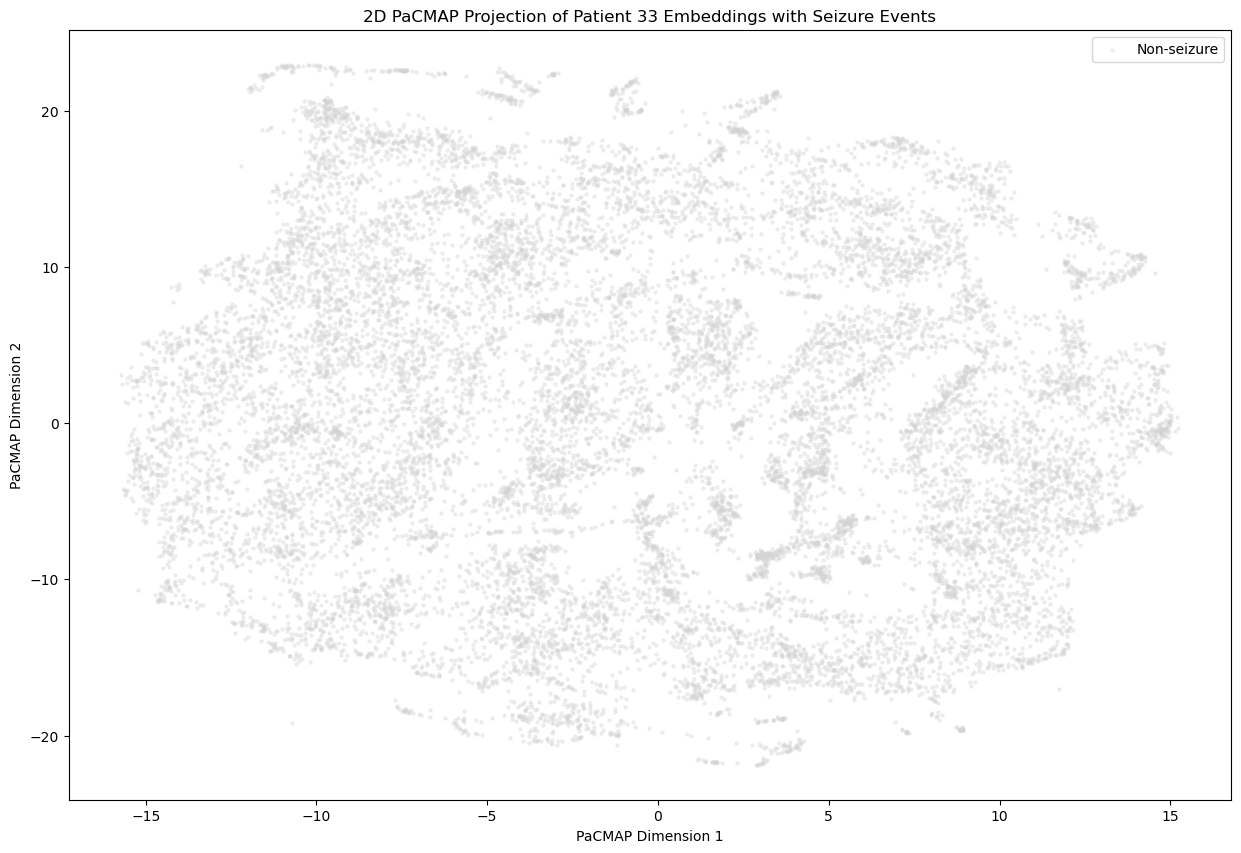

In [81]:
# Plot results
plt.figure(figsize=(15,10))

# Plot non-seizure points in grey first
plt.scatter(manifold_2d[~(seizure_mask | preictal_mask),0], 
           manifold_2d[~(seizure_mask | preictal_mask),1],
           c='lightgray', alpha=0.3, s=5, label='Non-seizure')

# Get indices of preictal points
preictal_indices = np.where(preictal_mask)[0]

# Get indices of seizure points 
seizure_indices = np.where(seizure_mask)[0]

# Plot preictal points with blue-purple gradient
if len(preictal_indices) > 0:
    # Create normalized values between 0 and 1 for the preictal points
    preictal_norm_values = np.linspace(0, 1, len(preictal_indices))
    
    # Plot preictal points with color gradient
    preictal_scatter = plt.scatter(manifold_2d[preictal_indices,0], 
                                 manifold_2d[preictal_indices,1],
                                 c=preictal_norm_values, cmap='cool',
                                 label=f'Pre-ictal progression ({len(preictal_indices)} windows)',
                                 alpha=0.7, s=15)
    
    # Add colorbar for preictal
    preictal_cbar = plt.colorbar(preictal_scatter)
    preictal_cbar.set_label('Pre-ictal progression (early → late)')

# Create color gradient for seizure progression
if len(seizure_indices) > 0:
    # Create normalized values between 0 and 1 for the seizure points
    norm_values = np.linspace(0, 1, len(seizure_indices))
    
    # Plot seizure points with color gradient
    scatter = plt.scatter(manifold_2d[seizure_indices,0], manifold_2d[seizure_indices,1],
                         c=norm_values, cmap='YlOrRd',
                         label=f'Seizure progression ({len(patient_seizures)} events)',
                         alpha=0.7, s=15)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Seizure progression (early → late)')

print(f"Plotting {len(seizure_indices)} seizure points and {len(preictal_indices)} preictal points")

plt.title(f'2D PaCMAP Projection of Patient {patient_id} Embeddings with Seizure Events')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.legend()